In [2]:
%load_ext autoreload
%autoreload 2

#%pip install keras-tuner


from pathlib import Path
import os
import sys
sys.path.insert(0, "..")
sys.path

import numpy as np
import seaborn as sns
sns.set_theme()

import pandas as pd

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator


from src.data import make_dataset


from src.visualization import visualize_simple





In [2]:
datadir_processed = Path("../data/processed")

In [3]:
data = []
labels = []

for f in sorted(os.listdir(datadir_processed)):
    folder = os.path.join(datadir_processed, f)
    if os.path.isdir(folder):
        #print(f"{f} is a target class")
        for i in sorted(os.listdir(folder)):
            image=tf.keras.preprocessing.image.load_img(folder+'/'+i, 
            target_size= (64,64))
            batch_size=32
            image=np.array(image)
            data.append(image)
            labels.append(f)

data = np.array(data)
#labels = np.array(labels)
labels = list(labels)
labels_text = labels
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
labels = to_categorical(labels)



X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.125,
                                                random_state=42)




# Pre-processing
#X_train = X_train.astype('float32') / 255.
#X_test = X_test.astype('float32') / 255
#X_valid = X_valid.astype('float32') / 255

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)


(12414, 64, 64, 3)
(3548, 64, 64, 3)
(1774, 64, 64, 3)


In [4]:
train_datagen = ImageDataGenerator(
    #rotation_range=35,
    rescale=1.0 / 255,
    #shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
)

valid_datagen = ImageDataGenerator(
    #rotation_range=35,
    rescale=1.0 / 255,
    #shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)

In [5]:
train_generator = train_datagen.flow(np.array(X_train),
                                       y_train,
                                       batch_size = 16,
                                       shuffle = False)

valid_generator = valid_datagen.flow(np.array(X_valid),
                                       y_valid,
                                       batch_size = 16,
                                       shuffle = False)


test_generator = test_datagen.flow(np.array(X_test),
                                     y_test,
                                     batch_size = 16,
                                     shuffle = False)

In [3]:
simple_model2 = keras.models.Sequential([

keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(64,64,3)),
keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu'),
keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)),
keras.layers.BatchNormalization(),

keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)),

keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu'),
keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)),

keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu'),
keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)),

keras.layers.Dropout(0.25),
keras.layers.Flatten(),
keras.layers.Dense(64, activation="relu"),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),
keras.layers.Dense(10, activation="softmax")
])

simple_model2.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 59, 59, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 57, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 57, 57, 32)       1

In [4]:

model_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

simple_model2.compile(optimizer=model_optimizer, loss="categorical_crossentropy",
metrics=["accuracy"])

reduceLR = ReduceLROnPlateau(monitor='val_accuracy', 
factor=.001, 
patience=2, 
min_delta=0.01, 
mode="auto")




In [8]:
#hist_simple_model2 = simple_model2.fit_generator(train_generator, validation_data = valid_generator, steps_per_epoch = 10, epochs=20,
#callbacks=[reduceLR])

hist_simple_model2 = simple_model2.fit(X_train, y_train, epochs=20,
validation_data=(X_valid, y_valid), 
callbacks=[reduceLR])

Epoch 1/20
388/388 [==============================] - 28s 71ms/step - loss: 1.7661 - accuracy: 0.3875 - val_loss: 2.1662 - val_accuracy: 0.2982 - lr: 0.0010
Epoch 2/20
388/388 [==============================] - 27s 70ms/step - loss: 1.3651 - accuracy: 0.5214 - val_loss: 1.6254 - val_accuracy: 0.4498 - lr: 0.0010
Epoch 3/20
388/388 [==============================] - 27s 71ms/step - loss: 1.2063 - accuracy: 0.5922 - val_loss: 1.2330 - val_accuracy: 0.5733 - lr: 0.0010
Epoch 4/20
388/388 [==============================] - 27s 70ms/step - loss: 1.1019 - accuracy: 0.6244 - val_loss: 1.2284 - val_accuracy: 0.5654 - lr: 0.0010
Epoch 5/20
388/388 [==============================] - 26s 67ms/step - loss: 1.0291 - accuracy: 0.6544 - val_loss: 1.3616 - val_accuracy: 0.5248 - lr: 0.0010
Epoch 6/20
388/388 [==============================] - 26s 67ms/step - loss: 1.0002 - accuracy: 0.6583 - val_loss: 0.9325 - val_accuracy: 0.6674 - lr: 1.0000e-06
Epoch 7/20
388/388 [==============================] - 

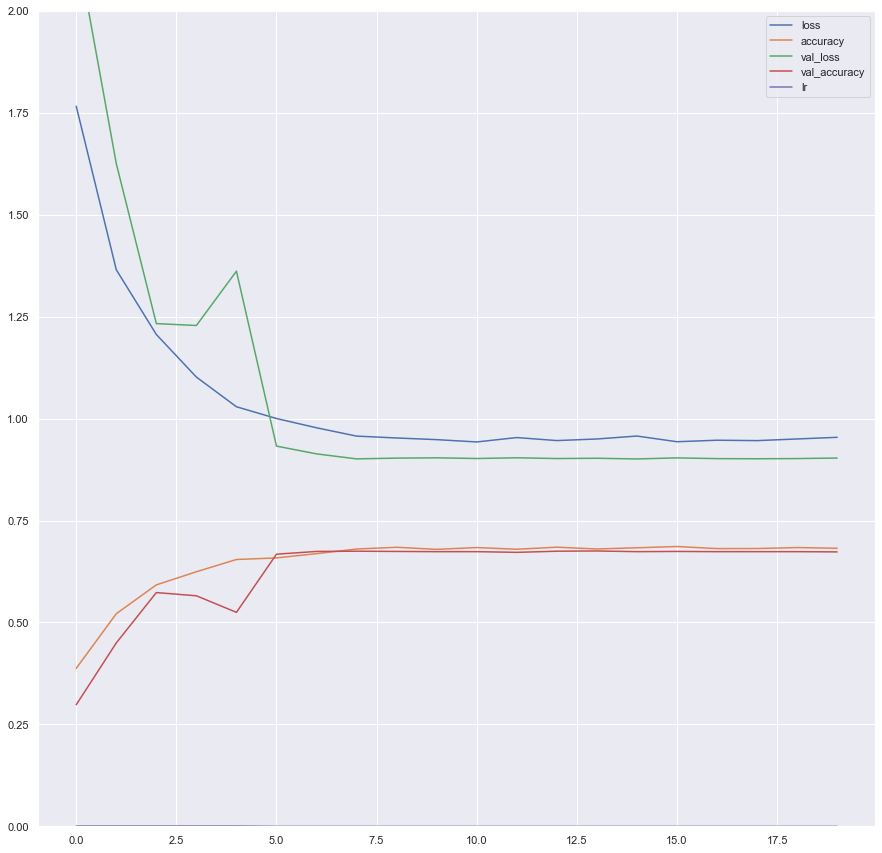

In [9]:
pd.DataFrame(hist_simple_model2.history).plot(figsize=(15, 15))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-2]
plt.show()

In [10]:
y_test = np.argmax(y_test,axis=1)
predict = simple_model2.predict(X_test).argmax(axis=1)


In [11]:
#encoder = LabelEncoder()
#y_test = encoder.fit_transform(y_test)
#predict = encoder.fit_transform(predict)

print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67       393
           1       0.62      0.22      0.33        68
           2       0.51      0.08      0.14       218
           3       0.72      0.85      0.78       378
           4       0.75      0.86      0.80       279
           5       0.73      0.57      0.64       380
           6       0.81      0.91      0.86       563
           7       0.69      0.89      0.78       399
           8       0.49      0.60      0.54       516
           9       0.71      0.49      0.58       354

    accuracy                           0.68      3548
   macro avg       0.67      0.62      0.61      3548
weighted avg       0.68      0.68      0.66      3548



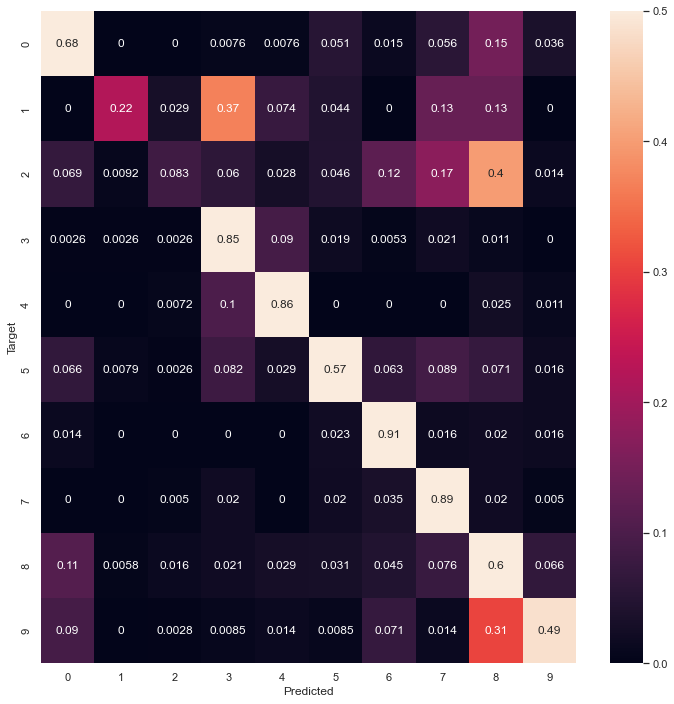

In [12]:
cfm = confusion_matrix(y_test, predict)
visualize_simple.cfm_heatmap(cfm, figsize=(12,12), scale='rowwise', vmax= 0.5)